In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2

#Visualization
import matplotlib.cm as cm
from sklearn import random_projection

import datetime

In [2]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32',
    'Week': 'int32',
    'Year':'int32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'

In [3]:
example = pd.read_csv(path,dtype=dtype_dict,parse_dates=['Date'],nrows = 1000,usecols = [1,2,3,4,5,6,7,8,9])
example.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0


In [4]:
df = pd.read_csv(r'D:\NOVAIMS_MAA\timeseries\agg_product_week_year.csv',dtype=dtype_dict,usecols = [1,2,3,4])

In [5]:
df.head()

,Year,Week,ProductName_ID,Quantity
0,2018,1,1000,664.0
1,2018,1,1002,533.0
2,2018,1,1003,729.0
3,2018,1,1004,715.0
4,2018,1,1007,420.0


In [6]:
# Check for top 10 products
df.groupby('ProductName_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductName_ID
2609    1622874.0
1277    1605002.0
226     1577078.0
2802    1419441.0
993     1329437.0
1147    1249097.0
481     1240714.0
1234    1200489.0
738     1199141.0
1422    1176504.0
Name: Quantity, dtype: float32

In [66]:
def preprocessing(dataframe,product_id):
    data = dataframe[dataframe['ProductName_ID'] == product_id]
    data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
    data['TimeSeries'] = data['Year'].astype('string') + data['Week']
    #drop non-relevant columns
    data.drop(['Year','Week','ProductName_ID'], axis=1, inplace=True)
    data.set_index('TimeSeries',inplace=True)
    return data

def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    dataset_val = dataset.values
    for i in range(interval, len(dataset)):
        value = dataset_val[i] - dataset_val[i - interval]
        diff.append(value[0])
    return pd.DataFrame({'diff':diff},index = dataset[1:].index)

def scale_func(df,size_split):
    len_df = df.shape[0]
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:int(len_df*size_split),:])
    scaled_data = scaler.transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

#create the training data set
def generate_input(df, window, out,size_split = 0.8):
    # df is the differencing dataframe
    #create the scaled training data set
    scaled_data, scaler = scale_func(df,size_split=size_split)
    #Split the data into x_train and y_train data sets
    len_df = scaled_data.shape[0]
    X = []
    Y = []
    for i in range(window, len(scaled_data)-out):
        X.append(scaled_data.iloc[i-window:i,:])
        Y.append(scaled_data.iloc[i:(i+out),:])
    X, Y = np.array(X), np.array(Y)
    Y = Y.reshape(Y.shape[0], Y.shape[1])
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    train_size = int(len_df*size_split)
    x_train = X[:train_size]
    y_train = Y[:train_size]
    x_val = X[train_size:]
    y_val = Y[train_size:]
    #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    return x_train, y_train, x_val,y_val, scaled_data,scaler

def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(10, return_sequences=True,  input_shape = input_shape))
    model.add(LSTM(10, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(y_train.shape[1]))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()
   

In [67]:
data = preprocessing(df,product_id='2609')

In [68]:
data

,Quantity
TimeSeries,
201801,15445.0
201802,17587.0
201803,16257.0
201804,15298.0
201805,15502.0
...,...
201940,18399.0
201941,20819.0
201942,18616.0


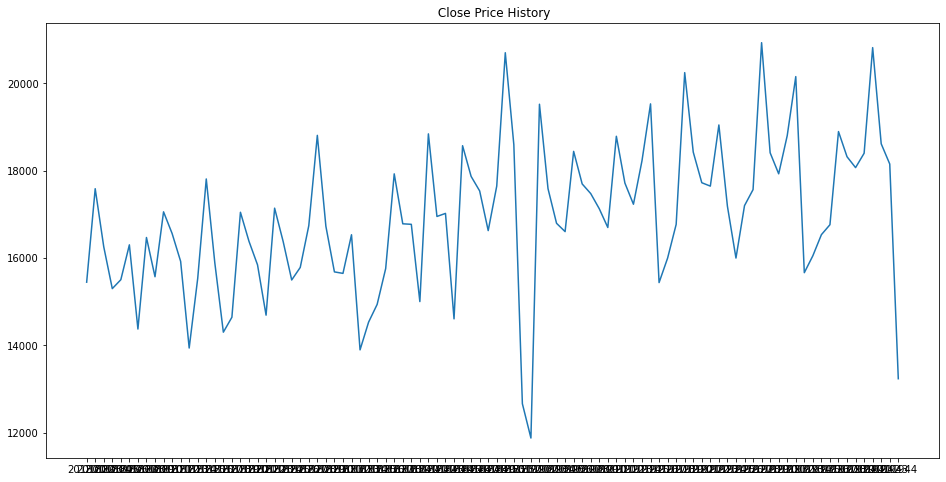

In [69]:
plt.figure(figsize=(16,8))
plt.title(' Close Price History')
plt.plot(data)

In [70]:
n = data.shape[0]
train_df = data[0:int(n*.8)]
val_df = data[int(n*0.8):]

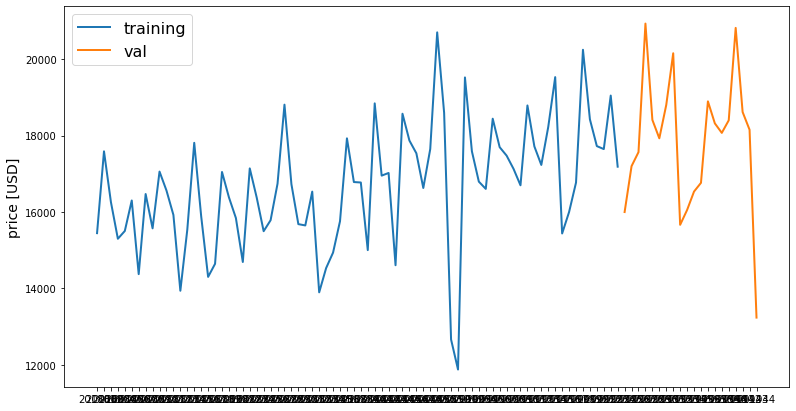

In [71]:
line_plot2(line1 = train_df, 
          line2 = val_df, label1='training',label2='val',title='')

In [72]:
dataset = difference(data)

In [73]:
x_train, y_train, x_val, y_val, scaled_df, scaler = generate_input(dataset,window = 6, out = 4)

In [74]:
print(scaled_df.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(95, 1)
(76, 6, 1)
(76, 4)
(9, 6, 1)
(9, 4)


In [83]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))
#train the model
history1 = LSTM1.fit(x_train, y_train, batch_size=8, epochs=60,validation_data=(x_val,y_val))

Epoch 1/60
10/10 [==============================] - 9s 173ms/step - loss: 0.2152 - val_loss: 0.1938
Epoch 2/60
10/10 [==============================] - 0s 7ms/step - loss: 0.1888 - val_loss: 0.1703
Epoch 3/60
10/10 [==============================] - 0s 8ms/step - loss: 0.1632 - val_loss: 0.1443
Epoch 4/60
10/10 [==============================] - 0s 8ms/step - loss: 0.1368 - val_loss: 0.1147
Epoch 5/60
10/10 [==============================] - 0s 8ms/step - loss: 0.1107 - val_loss: 0.0811
Epoch 6/60
10/10 [==============================] - 0s 8ms/step - loss: 0.0729 - val_loss: 0.0467
Epoch 7/60
10/10 [==============================] - 0s 8ms/step - loss: 0.0438 - val_loss: 0.0222
Epoch 8/60
10/10 [==============================] - 0s 8ms/step - loss: 0.0249 - val_loss: 0.0157
Epoch 9/60
10/10 [==============================] - 0s 8ms/step - loss: 0.0271 - val_loss: 0.0146
Epoch 10/60
10/10 [==============================] - 0s 8ms/step - loss: 0.0214 - val_loss: 0.0145
Epoch 11/60
10/10

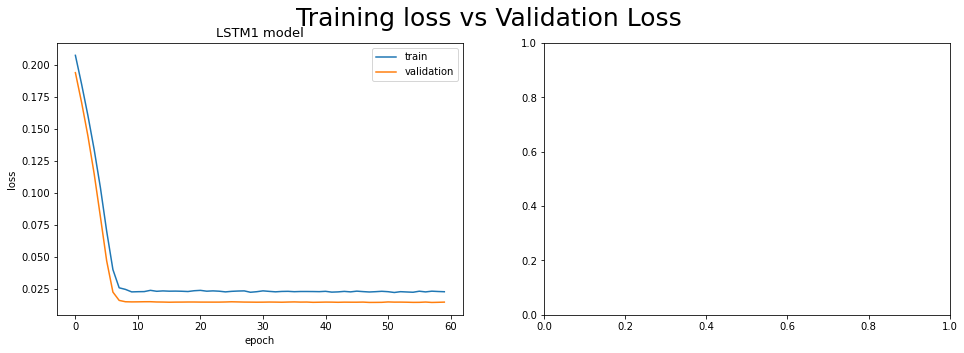

In [84]:

histories = [history1]
names = ['LSTM1']
plot_loss_histories(histories,names)

In [164]:
forecasts = LSTM1.predict(x_val)

In [165]:
forecasts

array([[0.45026127, 0.4523176 , 0.44495177, 0.4369349 ],
       [0.44540513, 0.44907445, 0.44383132, 0.43578142],
       [0.44789526, 0.44483626, 0.43392387, 0.42212814],
       [0.43099967, 0.42778474, 0.4192922 , 0.40589207],
       [0.43754888, 0.43547714, 0.42798883, 0.41696268],
       [0.43707258, 0.43651175, 0.43015802, 0.41931087],
       [0.43117875, 0.4352938 , 0.43227333, 0.4218296 ],
       [0.4274232 , 0.43298095, 0.42936504, 0.41694587],
       [0.44740918, 0.45154202, 0.4449429 , 0.43620315]], dtype=float32)

In [166]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
# inverse data transform on forecasts
def inverse_transform(data, forecasts, scaler, x_val):
    inverted = list()
    for i in range(len(forecasts)): 
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(data) - 1 - len(x_val) + i - out_put_len
        last_ob = data.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

In [169]:
inverse_transform(data,x_val,scaler,x_val)

[[array([20004.], dtype=float32),
  array([20371.], dtype=float32),
  array([23737.], dtype=float32),
  array([21215.], dtype=float32),
  array([20733.], dtype=float32),
  array([21608.], dtype=float32)],
 [array([20522.], dtype=float32),
  array([23888.], dtype=float32),
  array([21366.], dtype=float32),
  array([20884.], dtype=float32),
  array([21759.], dtype=float32),
  array([23111.], dtype=float32)],
 [array([19029.], dtype=float32),
  array([16507.], dtype=float32),
  array([16025.], dtype=float32),
  array([16900.], dtype=float32),
  array([18252.], dtype=float32),
  array([13760.], dtype=float32)],
 [array([13529.], dtype=float32),
  array([13047.], dtype=float32),
  array([13922.], dtype=float32),
  array([15274.], dtype=float32),
  array([10782.], dtype=float32),
  array([11170.], dtype=float32)],
 [array([16052.], dtype=float32),
  array([16927.], dtype=float32),
  array([18279.], dtype=float32),
  array([13787.], dtype=float32),
  array([14175.], dtype=float32),
  array([1

In [134]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))